In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xgcm
import xarray as xr
import sectionate
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

# Conservatively diagnosing model transports across arbitrary sections with `sectionate`

## Load example model grid and transport diagnosics

In [3]:
from example_dataset_grids import load_CM4p25
# this may be needed if files are on tape, copy/paste command and execute
#grid = load_CM4p25(z_coord="rho2", show_dmget=True)

In [4]:
grid = load_CM4p25(z_coord="rho2")
ds = grid._ds

## Diagnosing Meridional Overturning Streamfunctions

In [5]:
import xoverturning

#### Density vs. Nominal Latitude Overturning

It is straight-forward to calculate the nominal-MOC (along the grid's nominal latitude coordinate `y`) by integrated `Y`-face velocities `X` and `Z`.

In [6]:
ds_rho2 = grid._ds.isel(yq=slice(1,None),xq=slice(1,None))
%time moc_nominal = xoverturning.calcmoc(ds_rho2, dsgrid=ds_rho2, vertical='rho2').compute()

generating basin codes
CPU times: user 28.2 s, sys: 5.91 s, total: 34.1 s
Wall time: 36.3 s


(1038.0, 1028.0)

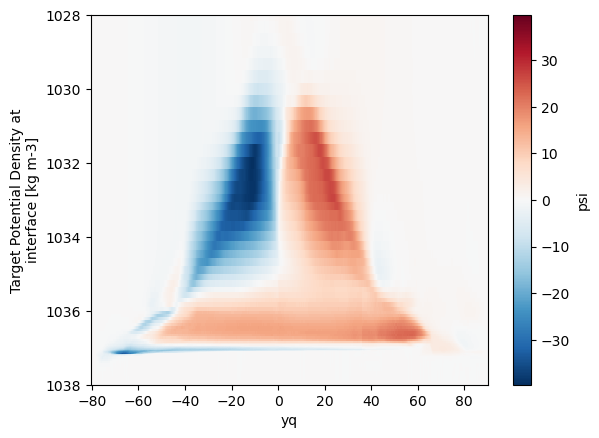

In [7]:
moc_nominal.mean('time').plot(x="yq")
plt.ylim(1038, 1028)

However, this is not actually the true latitudinal-MOC, which would be aligned with the `geolat` coordinate.

#### Density vs. Latitude Overturning

Using `sectionate`, we can compute the true northward transports across each latitude band and use these to compute the true latitudinal-MOC.

**Note**: This operation takes long because of the many calls to `infer_grid_path` within sectionate, which is not presently vectorized. Once the section indices are computed however, the actually extraction of transports from the mass transport diagnostics takes no longer than the `calcmoc` method of `xoverturning`. Alternatively, sectionate's sibling package [**regionate**](https://github.com/hdrake/regionate) can be used used to more directly infer sections from the boundaries of Boolean masks (e.g. `ds.geolat < lat`), which makes the calculation only about twice as slow as `xoverturning.calcmoc`.

In [8]:
names_rho2 = {'x_center': 'sect',
              'layer': 'rho2_l',
              'interface': 'rho2_i'}

In [9]:
def transport_across_latitude_line(grid, lat, dlon=5.):
    section_lons=np.arange(0., 360.+dlon, dlon)
    section_lats=[lat]*len(section_lons)
    i, j, lons, lats = sectionate.grid_section(
        grid,
        section_lons,
        section_lats,
        topology="MOM-tripolar"
    )
    conv_transport = sectionate.convergent_transport(grid, i, j, layer="rho2_l", interface="rho2_i")
    northward_transport = -xoverturning.compfunc.compute_streamfunction(conv_transport, names_rho2, transport='conv_mass_transport')
    
    return northward_transport.expand_dims({'lat': xr.DataArray([lat], dims=('lat',))})

def global_moc(grid, dlat=1.):
    return xr.concat([transport_across_latitude_line(grid, lat) for lat in np.arange(-76, 90., dlat)], dim="lat")

In [10]:
dlat = 1.
%time moc = global_moc(grid, dlat=dlat).compute()

CPU times: user 1h 58min 32s, sys: 41.1 s, total: 1h 59min 13s
Wall time: 2h 24s


#### Difference between the nominal-MOC (along the `yh` coordinate) and the latitudinal-MOC (along the `geolat` coordinate)

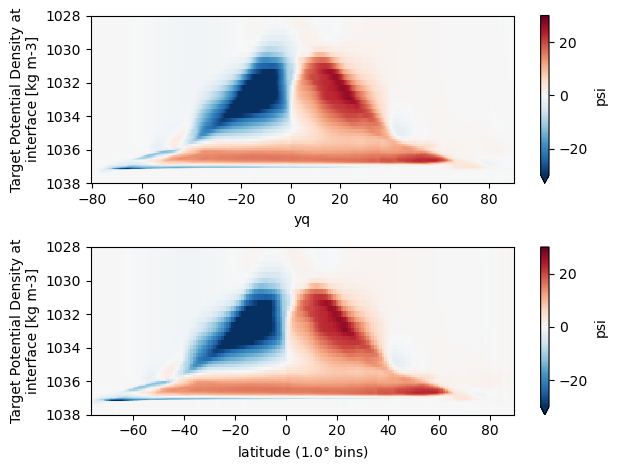

In [11]:
plt.subplot(2,1,1)
moc_nominal.mean('time').plot(x="yq", vmin=-30, vmax=30., cmap="RdBu_r")
plt.ylim(1038, 1028)

plt.subplot(2,1,2)
moc.mean('time').plot(x="lat", vmin=-30, vmax=30., cmap="RdBu_r")
plt.ylim(1038, 1028)
plt.xlabel(fr"latitude ({dlat}$\degree$ bins)");
plt.tight_layout()

Zooming in on the Arctic bipolar region, we do notice some significant differences in terms of the meridional structure of the overturning in the high Arctic.

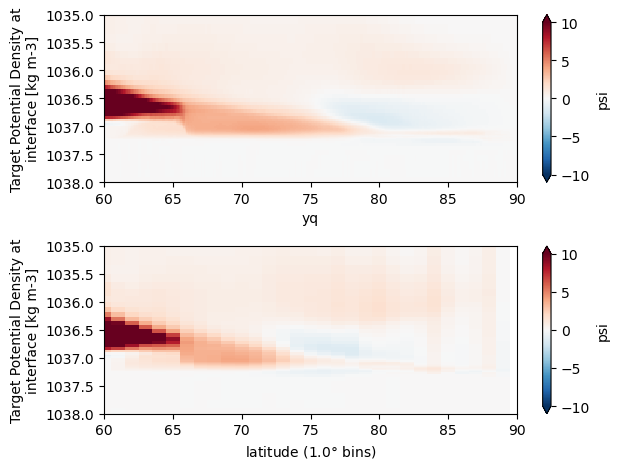

In [12]:
plt.subplot(2,1,1)
moc_nominal.mean('time').plot(x="yq", vmin=-10, vmax=10., cmap="RdBu_r")
plt.ylim(1038, 1035)
plt.xlim(60, 90)

plt.subplot(2,1,2)
moc.mean('time').plot(x="lat", vmin=-10, vmax=10., cmap="RdBu_r")
plt.ylim(1038, 1035)
plt.xlim(60, 90)
plt.xlabel(fr"latitude ({dlat}$\degree$ bins)");
plt.tight_layout()